# EXAMPLE : RANDOM FOREST FOR GRADE CLASSIFICATION
*by: nofitaika*

Analisis ini bertujuan untuk mengklasifikasikan pemilihan loan grade berdasarkan beberapa faktor yang mempengaruhi. Data yang digunakan adalah data [Lending Club](https://www.lendingclub.com/info/download-data.action) tahun 2015. Klasifikasi ini dapat digunakan sebagai pelengkap visualisasi BI untuk menentukan strategi bisnis agar lebih tepat sasaran.

## Persiapan Data
Lending_club_loan_data yang didownload langsung dari websitenya adalah data asli dengan 144 variabel dan beberapa permasalahan data. Oleh karena itu perlu dilakukan persiapan untuk mendapatkan data yang bersih sesuai dengan kebutuhan dan siap dianalisis. Beberapa langkah dalam persiapan data ini adalah sebagai berikut, (sebelumnya, berikut ini ditampilkan preview data yang digunakan).

In [1]:
lending_club_loan_data <- readRDS("C:/Users/ASUS/Downloads/lending_club_loan_data.rds")
head(lending_club_loan_data)

member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
NA,24700,24700,24700,36 months,11.99,820.28,C,C1,Engineer,...,NA,NA,Cash,N,NA,NA,NA,NA,NA,NA
NA,35000,35000,35000,60 months,12.88,794.21,C,C2,Lieutenant,...,NA,NA,Cash,N,NA,NA,NA,NA,NA,NA
NA,20000,20000,20000,60 months,13.99,465.27,C,C4,Facilities Coordinator,...,NA,NA,Cash,Y,Nov-2017,COMPLETE,Sep-2017,9915,55,1
NA,20000,20000,20000,36 months,12.88,672.73,C,C2,President,...,NA,NA,Cash,N,NA,NA,NA,NA,NA,NA
NA,14025,14025,14025,60 months,18.49,359.90,D,D5,accts payable,...,NA,NA,Cash,N,NA,NA,NA,NA,NA,NA
NA,16000,16000,16000,60 months,8.49,328.19,B,B1,Supervisor,...,NA,NA,Cash,N,NA,NA,NA,NA,NA,NA


### a. Memilih Variabel yang digunakan
Beberapa variabel yang diduga mempengaruhi keputusan peminjam dalam menentukan loan grade adalah pendapatan per tahun(annual_inc), negara asal(addr_state), status kepemilikan rumah(home_ownership), dan tipe pinjaman(application_type). Berikut ini adalah seleksi 5 variabel tersebut ditambah variabel issue_d(tanggal pinjaman) yang akan digunakan untuk seleksi data tahun 2015 (hal ini tidak perlu dilakukan jika pada saat download data sudah sesuai hanya tahun 2015 saja)

In [2]:
library(dplyr)

#memilih variabel yang digunakan
needed_var <- c('grade','annual_inc','home_ownership','addr_state','application_type','issue_d')
first_sel<-select(lending_club_loan_data, needed_var)

#seleksi data tahun 2015
sec_sel <- dplyr::filter(first_sel, grepl('2015', issue_d))
head(sec_sel)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



grade,annual_inc,home_ownership,addr_state,application_type,issue_d
C,65000,MORTGAGE,SD,Individual,Dec-2015
C,106000,MORTGAGE,AL,Individual,Dec-2015
C,70000,OWN,MD,Individual,Dec-2015
C,145000,MORTGAGE,RI,Individual,Dec-2015
D,39000,MORTGAGE,WI,Individual,Dec-2015
B,62000,MORTGAGE,CA,Individual,Dec-2015


### b. Mendeteksi Missing Data

In [3]:
sum(is.na(sec_sel))

[1] 0

Data yang diseleksi tidak memiliki *missing value*.

### c. Mendeteksi dan Menangani Outlier
Dalam persiapan data ini diperlukan deteksi dan penanganan outlier karena variabel annual_inc yang memiliki type data numeric akan diubah menjadi data kategori, yakni annual_inc dengan nilai lebih dari rata-ratanya dan kurang dari rata-ratanya.

In [4]:
outlierKD <- function(dt, var) {
  var_name <- eval(substitute(var),eval(dt))
  tot <- sum(!is.na(var_name))
  na1 <- sum(is.na(var_name))
  m1 <- mean(var_name, na.rm = T)
  par(mfrow=c(2, 2), oma=c(0,0,3,0))
  boxplot(var_name, main="With outliers")
  hist(var_name, main="With outliers", xlab=NA, ylab=NA)
  outlier <- boxplot.stats(var_name)$out
  mo <- mean(outlier)
  var_name <- ifelse(var_name %in% outlier, NA, var_name)
  boxplot(var_name, main="Without outliers")
  hist(var_name, main="Without outliers", xlab=NA, ylab=NA)
  title("Outlier Check", outer=TRUE)
  na2 <- sum(is.na(var_name))
  message("Outliers identified: ", na2 - na1, " from ", tot, " observations")
  message("Proportion (%) of outliers: ", (na2 - na1) / tot*100)
  message("Mean of the outliers: ", mo)
  m2 <- mean(var_name, na.rm = T)
  message("Mean without removing outliers: ", m1)
  message("Mean if we remove outliers: ", m2)
  response <- readline(prompt="Do you want to remove outliers and to replace with NA? [yes/no]: ")
  if(response == "y" | response == "yes"){
    dt[as.character(substitute(var))] <- invisible(var_name)
    assign(as.character(as.list(match.call())$dt), dt, envir = .GlobalEnv)
    message("Outliers successfully removed", "\n")
    return(invisible(dt))
  } else{
    message("Nothing changed", "\n")
    return(invisible(var_name))
  }
}

Source code : [link](https://datascienceplus.com/identify-describe-plot-and-removing-the-outliers-from-the-dataset/). 
Syntax tersebut akan memberikan otput boxplot dan histogram dari variabel yang akan dicek untuk kondisi sebelum dan sesudah dihapus outliernya. Identifikasi jumlah outlier, mean dari data outlier, mean data asli, dan mean data jika outlier tertangani juga ditampilkan. Sehingga kita dapat memutuskan untuk menangani outlier dengan menggantinya menjadi NA atau tidak.

Outliers identified: 16501 from 336867 observations
Proportion (%) of outliers: 4.89837235466816
Mean of the outliers: 241354.536122053
Mean without removing outliers: 76912.0200629625
Mean if we remove outliers: 68442.1263866952


Do you want to remove outliers and to replace with NA? [yes/no]: yes


Outliers successfully removed



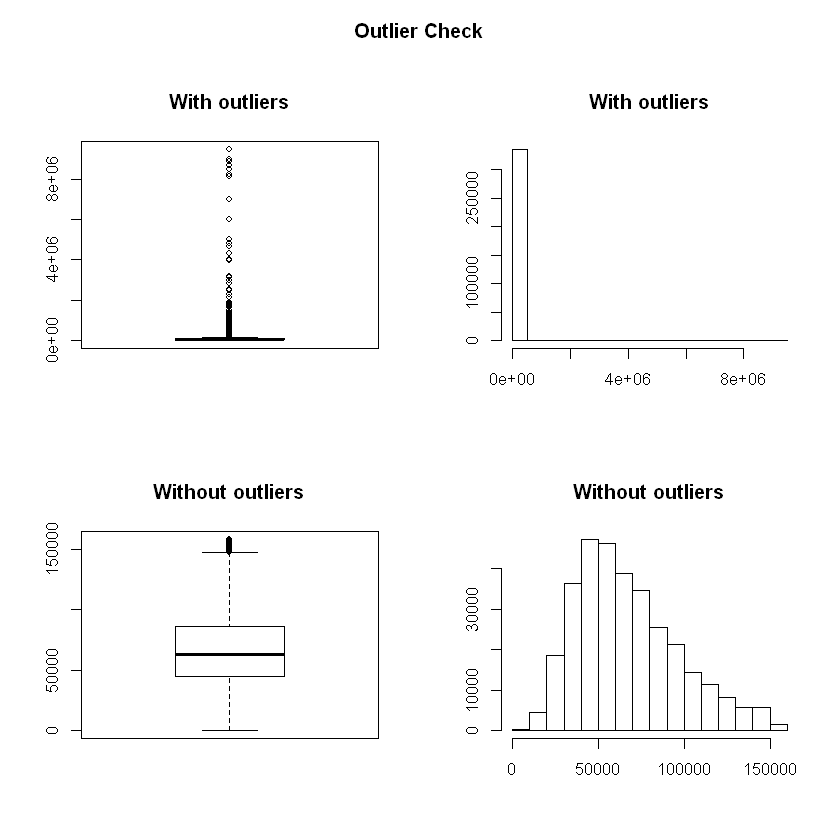

In [5]:
third_sel <- outlierKD(sec_sel, annual_inc)

Berdasarkan *summary* tersebut dapat diketahui bahwa mean dari data yang outlier sangat jauh dengan mean data jika tanpa outlier. Oleh karena itu diputuskan untuk menangani outlier dengan mengantinya menjadi data NA agar pengelompokan data annual_inc menjadi lebih baik. Selanjutnya data NA tersebut dihapus seperti berikut.

In [6]:
#menghapus NA
third_sel <- na.omit(third_sel)

#dimensi data
dim(third_sel)

[1] 320366      6

Sekarang data outlier telah dihapus, yang awalnya terdapat 336867 observations menjadi 320366 observations dengan 6 kolom.

### d. Mengubah Nilai Variabel annual_inc menjadi Kategori
Perubahan ini dilakukan karena dengan mempersempit sebaran nilai diharapkan dapat mempermudah menentukan strategi dalam pemasaran produk.

In [7]:
four_sel <- mutate(third_sel,income_cat = ifelse(annual_inc>=mean(annual_inc),"lebih", "kurang") )
glimpse(four_sel)

Observations: 320,366
Variables: 7
$ grade            <chr> "C", "C", "C", "C", "D", "B", "C", "B", "C", "C", ...
$ annual_inc       <dbl> 65000, 106000, 70000, 145000, 39000, 62000, 39750,...
$ home_ownership   <chr> "MORTGAGE", "MORTGAGE", "OWN", "MORTGAGE", "MORTGA...
$ addr_state       <chr> "SD", "AL", "MD", "RI", "WI", "CA", "IL", "IL", "P...
$ application_type <chr> "Individual", "Individual", "Individual", "Individ...
$ issue_d          <chr> "Dec-2015", "Dec-2015", "Dec-2015", "Dec-2015", "D...
$ income_cat       <chr> "kurang", "lebih", "lebih", "lebih", "kurang", "ku...


Dari ringkasan tersebut diketahui bahwa data yang awalnya 6 kolom kini menjadi 7 kolom karena ada tambahan variabel income_cat. Variabel tersebut merupakan annual_inc yang telah diubah menjadi kategori dengan aturan nilai annual_inc akan diberi label 'lebih' jika nilanya lebih dari rata-rata annual_inc dan sebaliknya.

### e. Mengubah Type Data
Dari ringkasan di atas diketahui bahwa semua data yang akan digunakan dalam analisis Random Forest ini memiliki type *char*(character). Sedangkan fungsi Random Forest untuk klasifikasi memerlukan type *fct*(factor).

In [8]:
four_sel$grade <- as.factor(four_sel$grade)
four_sel$home_ownership <- as.factor(four_sel$home_ownership)
four_sel$addr_state <- as.factor(four_sel$addr_state)
four_sel$application_type <- as.factor(four_sel$application_type)
four_sel$income_cat <- as.factor(four_sel$income_cat)
glimpse(four_sel)

Observations: 320,366
Variables: 7
$ grade            <fct> C, C, C, C, D, B, C, B, C, C, D, B, D, B, A, C, C,...
$ annual_inc       <dbl> 65000, 106000, 70000, 145000, 39000, 62000, 39750,...
$ home_ownership   <fct> MORTGAGE, MORTGAGE, OWN, MORTGAGE, MORTGAGE, MORTG...
$ addr_state       <fct> SD, AL, MD, RI, WI, CA, IL, IL, PA, NJ, OH, FL, OH...
$ application_type <fct> Individual, Individual, Individual, Individual, In...
$ issue_d          <chr> "Dec-2015", "Dec-2015", "Dec-2015", "Dec-2015", "D...
$ income_cat       <fct> kurang, lebih, lebih, lebih, kurang, kurang, kuran...


## Analisis Random Forest

### a. Menentukan Data Training dan Data Testing
Data training merupakan data yang digunakan untuk menentukan model random forest. Sedangkan data testing merupakan data yang digunakan untuk menguji model yang sudah diperoleh. Dengan kata lain, data yang sudah siap dianalisis tersebut dibagi menjadi dua. Proporsi pembagiannya bebas ditentukan dengan preferensi masing - masing. Untuk analisis ini proporsi yang digunakan adalah 0.5 karena data yang akan dianalisis memiliki observasi yang cukup besar, sehingga dengan mengambil setengahnya dirasa cukup kuat untuk membuat model.

In [9]:
 library(caTools)
 set.seed(123)
 split <- sample.split(four_sel$grade,SplitRatio = 0.5)
 training_set <- subset(four_sel,split==TRUE)
 summary(training_set)
 testing_set <- subset(four_sel,split==FALSE)
 summary(testing_set)

Warning message:
"package 'caTools' was built under R version 3.6.1"

 grade       annual_inc      home_ownership    addr_state   
 A:26924   Min.   :     0   ANY     :    1   CA     :21805  
 B:44636   1st Qu.: 45000   MORTGAGE:77349   TX     :12956  
 C:46270   Median : 63000   OWN     :17386   NY     :12767  
 D:24290   Mean   : 68382   RENT    :65446   FL     :11241  
 E:13452   3rd Qu.: 86000                    IL     : 6376  
 F: 3780   Max.   :158500                    PA     : 5637  
 G:  830                                     (Other):89400  
   application_type    issue_d           income_cat   
 Individual:159994   Length:160182      kurang:90313  
 Joint App :   188   Class :character   lebih :69869  
                     Mode  :character                 
                                                      
                                                      
                                                      
                                                      

 grade       annual_inc      home_ownership    addr_state   
 A:26923   Min.   :  1200   ANY     :    1   CA     :21702  
 B:44637   1st Qu.: 45000   MORTGAGE:77766   TX     :13110  
 C:46270   Median : 63000   OWN     :17522   NY     :12677  
 D:24291   Mean   : 68503   RENT    :64895   FL     :11201  
 E:13453   3rd Qu.: 86000                    IL     : 6422  
 F: 3780   Max.   :158500                    PA     : 5810  
 G:  830                                     (Other):89262  
   application_type    issue_d           income_cat   
 Individual:159973   Length:160184      kurang:90182  
 Joint App :   211   Class :character   lebih :70002  
                     Mode  :character                 
                                                      
                                                      
                                                      
                                                      

### b. Random Forest

In [10]:
library(randomForest)
  
#membuat model
form <- grade ~ home_ownership + addr_state + application_type + income_cat
model1 <- randomForest(form,data=training_set,importance=TRUE)
  
importance(model1)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine



ERROR: Error: cannot allocate vector of size 611.0 Mb


Kurang lebih syntax yang digunakan untuk memodelkan random forest adalah seperti di atas. Namun untuk ukuran data yang digunakan ini Jupyter Notebook tidak mampu memprosesnya. Syntax "importance(model)" tersebut akan memberikan informasi variabel mana yang memberikan efek lebih besar untuk variabel respon. Berikut ini adalah output dengan syntax yang sama namun menggunakan ukuran data yang lebih kecil.

In [12]:
# menentukan data training untuk ukuran yang lebih kecil 
 split1 <- sample.split(four_sel$grade,SplitRatio = 0.2)
 training_set1 <- subset(four_sel,split1==TRUE)
 testing_set1 <- subset(four_sel,split1==FALSE)

#membuat model
 form1 <- grade ~ home_ownership + addr_state + application_type + income_cat
 model2 <- randomForest(form,data=training_set1,importance=TRUE)

importance(model2)

,A,B,C,D,E,F,G,MeanDecreaseAccuracy,MeanDecreaseGini
home_ownership,-1.745103,-2.555038,16.406741,-6.828029,-6.6152021,-1.886261971,0,30.845005,68.77237
addr_state,-7.670952,-0.637401,12.400683,-3.066768,-6.4090814,-2.027495971,0,18.664890,143.72715
application_type,-2.091754,8.827435,-3.578024,10.656731,11.2385135,0.007768292,0,9.258623,15.33008
income_cat,10.270078,16.069112,34.175854,-4.501769,0.5172471,-1.117623195,0,75.533986,199.58164


Dari tabel output tersebut dapat diperhatikan nilai dari MeanDecreaseAccuracy untuk menentukan variabel yang memberikan pengaruh terbesar bagi variabel responnya. Semakin besar nilai MDA, maka variabel itulah yang paling memberikan pengaruh. Sehingga dalam analisis ini dapat disimpulkan bahwa penghasilan per tahun memberikan pengaruh besar dalam penentuan grade pinjaman. 

[BERIKUT INI](https://cloud.smartdraw.com/share.aspx/?pubDocShare=D94DD983DBFA4C2DD9DC8B137D56ED516B5) adalah salah satu bentuk pohon untuk analisis dan data yang sama (data testing = 0,5) namun menggunakan bantuan visualisasi Microsoft AML.

Beberapa hal yang dapat diambil dari satu pohon tersebut adalah,
1. faktor yang paling berpengaruh adalah **income** (sesuai dengan tabel output importance)
2. kategori dengan income "kurang" banyak yang memilih grade C, A, dan B dengan tanpa ada grade F
3. kategori dengan income "lebih" banyak yang memilih grade B, E, dan C dengan tanpa ada grade A